In [1]:
from gensim.models import Word2Vec
from tqdm import tqdm
import tqdm.notebook as tq
import pandas as pd
import nltk
import numpy as np
import gensim
import itertools
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import shutil
import re
import random as rn
import datetime
from sklearn.metrics.pairwise import cosine_similarity
from argparse import ArgumentParser
tqdm.pandas()


In [2]:
parser = ArgumentParser()
parser.add_argument("-r", "--run", type=int)
parser.add_argument("-i", "--iterations", type=int)
parser.add_argument("-z", "--size", type=int)
parser.add_argument("-n", "--rows", type=str)

args = vars(parser.parse_args())
run = args['run']
iterations = args['iterations']
vector_size = args['size']
no_rows = args['rows']

# run = 0
# iterations = 2
# vector_size = 100
# no_rows = '100000'

if no_rows.isdecimal():
    no_rows = int(no_rows)

In [3]:
df = pd.read_csv('../out_files/tell_all_cleaned.csv')

print(df.shape)
df = df[df['speech'].notna()]
print(df.shape)
df.speech.iloc[0]

print('Preparing data...')

#New column year
df.sitting_date = pd.to_datetime(df.sitting_date, format="%d/%m/%Y") 
df['year'] = df['sitting_date'].dt.year
df['decade'] = (df['year']//10)*10
df = df[df.decade != 1980] # remove dates before 2000 to catch the three last decades
df = df[df.decade != 2020]# remove dates after 2019 to catch the three last decades
df = df[df.decade != 2000]# remove dates after 2019 to catch the three last decades

print(set(df.decade.to_list()))

(1280918, 12)
(1274505, 12)
Preparing data...
{2010, 1990}


In [4]:
df.speech.iloc[1]

'κυριοι συναδελφοι @sw προχωρησουμε @sw ορκωμοσια @sw συναδελφου βασιλη κοραχαη.παρακαλειται @sw βασιλης κοραχαης @sw προσελθει @sw @sw ορκισθει.ορκιζομαι @sw ονομα @sw αγιας @sw ομοουσιας @sw αδιαιρετης τριαδας @sw @sw πιστος @sw πατριδα @sw @sw δημοκρατικο πολιτευμα @sw υπακουω @sw συνταγμα @sw @sw νομους @sw @sw εκπληρω ευσυνειδητα @sw καθηκοντα @sw'

In [5]:
print('Group by decades...')
print(datetime.datetime.now())
df.speech = df.speech.progress_apply(lambda x: x.replace('\n', ' '))
PERdecade_df = df.groupby(df.decade)['speech'].progress_apply('.'.join).reset_index() #concat sentences, each last sentence for each speech did not have dot so add one.
PERdecade_df.speech = PERdecade_df.speech.progress_apply(lambda x: [sent.split(' ') for sent in x.split('.')])
PERdecade_df.speech = PERdecade_df.speech.progress_apply(lambda x: [token for token in x if token!='' and token!=' '])

print(PERdecade_df.head())

Group by decades...
2021-09-17 16:28:14.454079


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.86it/s]

   decade                                             speech
0    1990  [[κυριοι, συναδελφοι, αρχιζει, @sw, συνεδριαση...
1    2010  [[κυριες, @sw, κυριοι, συναδελφοι, @sw, @sw, ε...


In [6]:
if isinstance(no_rows, str):
    if no_rows =='all':
        pass
    else:
        print('Undefined row number')
else:

    PERdecade_df.speech[0] = PERdecade_df.speech[0][:no_rows]
    PERdecade_df.speech[1] = PERdecade_df.speech[1][:no_rows]
#     print(len(PERdecade_df.speech.iloc[0]))
#     print(len(PERdecade_df.speech.iloc[1]))
#     print(PERdecade_df.head())

/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [7]:
def compute_cosine_similarity(model1,model2,word):
    vector1 = model1.wv[word].reshape(1,-1)
    vector2 = model2.wv[word].reshape(1,-1)
    return(cosine_similarity(X=vector1, Y=vector2)[0][0])

def step_one_pairs(list_of_items):
    return [(list_of_items[i],list_of_items[i+1]) for i in range(len(list_of_items)-1)]


In [8]:
models_dir =  '../out_files/wordmodels/hamilton_stability/'

if not os.path.exists(models_dir):
    print('Creating models directory...')
    os.makedirs(models_dir)
    
PERdecade_df.sort_values(by='decade')
decades = sorted(PERdecade_df.decade.to_list())
decade_pairs = step_one_pairs(decades)

shifts_PERdecade_list = []

for i in range(iterations):
    
    np.random.seed(i)
    rn.seed(i)
    my_seed=i
        
    print('********************************************************')
    print('Repeat No ', str(i))
    
    print(datetime.datetime.now())
    
    print('Training models for each decade...')

    for decade, texts in tqdm(zip(PERdecade_df.decade, PERdecade_df.speech)):
        print(decade)
        model = Word2Vec(sentences=texts, size=vector_size, window=5, min_count=20, workers=1, seed=my_seed)
        model.save(models_dir+str(decade)+'_'+str(i)+ ".mdl")

    print(datetime.datetime.now())
    
    
    m1 = Word2Vec.load(models_dir+str(decades[0])+'_'+str(i)+ ".mdl")
    m2 = Word2Vec.load(models_dir+str(decades[1])+'_'+str(i)+ ".mdl")
    
    common_vocab = list(set(m1.wv.vocab).intersection(set(m2.wv.vocab)))
    print('Common vocab length... ', str(len(common_vocab)))
    print('Computing word similarity between decades....')
    

    for word in tq.tqdm(common_vocab):

        #union of neighbors in two points in time
        neighbors_t1 = [w for w,s in m1.wv.most_similar(positive=[word], topn=25)]
        neighbors_t2 = [w for w,s in m2.wv.most_similar(positive=[word], topn=25)]
        neighbors_union = [n for n in list(set(neighbors_t1+neighbors_t2)) if n in common_vocab]

        # similarity vector for time point 1 (t1)
        # each element is the cosine similarity of topic vector in t1 and each neighbor from neighbors_union
        similarity_vector_t1 = []
        word_vector_t1 = m1.wv[word]
        
        for nn in neighbors_union:
            neighbor_vector = m1.wv[nn]
            similarity_vector_t1.append(cosine_similarity(X=word_vector_t1.reshape(1,-1), Y=neighbor_vector.reshape(1,-1))[0][0])

        # similarity vector for time point 2 (t2)
        # each element is the cosine similarity of topic vector in t2 and each neighbor from neighbors_union
        similarity_vector_t2 = []
        word_vector_t2 = m2.wv[word]
        
        for nn in neighbors_union:
            neighbor_vector = m2.wv[nn]
            similarity_vector_t2.append(cosine_similarity(X=word_vector_t2.reshape(1,-1), Y=neighbor_vector.reshape(1,-1))[0][0])

        # final cosine between cosines/ similarity vectors for t1 and t2
        result = cosine_similarity(np.array([similarity_vector_t1]),
                                   np.array([similarity_vector_t2])
                                  )[0][0]

        shifts_PERdecade_list.append([i, '1990-2010', word, result, len(common_vocab), neighbors_t1, neighbors_t2, len(neighbors_union),])


shifts_PERdecade_df = pd.DataFrame(
    data=shifts_PERdecade_list, columns=['iteration', 'decade', 'word', 'semantic_similarity', 'common_vocab', 'top25neighbors_1st_decade', 'top25neighbors_2nd_decade', 'neighbors_union'])


shifts_PERdecade_df.describe()

shifts_PERdecade_df = shifts_PERdecade_df.sort_values('semantic_similarity', ascending=False).reset_index(drop=True)
print(shifts_PERdecade_df.head(5))
print('------------')
print(shifts_PERdecade_df.tail(5))


shifts_PERdecade_df.to_csv('../out_files/stability_hamilton_run'+str(run)+'_iterations'+str(
    iterations)+'_size'+str(vector_size)+'_rows'+str(no_rows)+'.csv', index=False)


********************************************************
Repeat No  0
2021-09-17 16:28:31.483261
Training models for each decade...


0it [00:00, ?it/s]

1990


/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
1it [00:06,  6.94s/it]

2010


/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2it [00:14,  7.38s/it]

2021-09-17 16:28:46.236893
Common vocab length...  5371
Computing word similarity between decades....



/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


  0%|          | 0/5371 [00:00<?, ?it/s]

********************************************************
Repeat No  1
2021-09-17 16:30:50.175601
Training models for each decade...


0it [00:00, ?it/s]

1990


/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
1it [00:06,  6.87s/it]

2010


/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2it [00:14,  7.28s/it]

2021-09-17 16:31:04.744402
Common vocab length...  5371
Computing word similarity between decades....



/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/dina/Documents/repos/paper_greekparliament/.parl_env/lib/python3.7/site-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


  0%|          | 0/5371 [00:00<?, ?it/s]

   iteration     decade          word  semantic_similarity  common_vocab  \
0          0  1990-2010     αποστολος             0.999499          5371   
1          1  1990-2010     αποστολος             0.999316          5371   
2          0  1990-2010  παπαδοπουλος             0.999062          5371   
3          1  1990-2010       μιχαλης             0.999034          5371   
4          1  1990-2010     σκουλακης             0.998961          5371   

                           top25neighbors_1st_decade  \
0  [θεοδωρος, αθανασιος, βασιλειος, κωνσταντινος,...   
1  [θεοδωρος, μιχαηλ, κυριακος, δημητρης, γεωργιο...   
2  [σπυρος, μελιδης, βασιλης, σταθοπουλος, δημητρ...   
3  [βασιλης, φωτιαδης, σπυρος, μανολης, μανωλης, ...   
4  [μπαντουβας, φουρας, σιουφας, σγουριδης, ανδρο...   

                           top25neighbors_2nd_decade  neighbors_union  
0  [νανος, αναστασιος, κυριακος, παυλος, θεοδωρα,...               20  
1  [νανος, σπυριδων, μιλτιαδης, παυλος, μαρκακης,...          

[10, 20, 50, 100, 200, 500, 1000] [0.4, 0.6, 0.62, 0.53, 0.445, 0.496, 0.583]


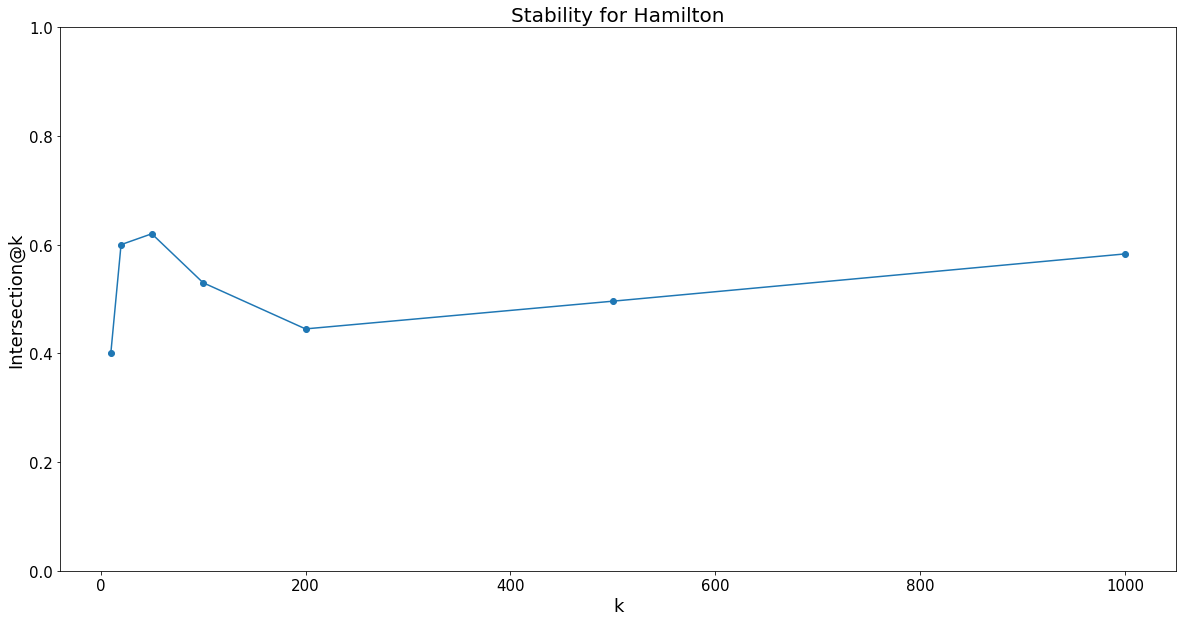

In [9]:
topn_dict = {}
X = []
Y = []

k=[10,20,50,100,200,500,1000]

for n in k:
    
    for iteration in range(iterations):
        subdf = shifts_PERdecade_df.loc[(shifts_PERdecade_df.iteration==iteration)]
        subdf = subdf.sort_values('semantic_similarity', ascending=False).reset_index(drop=True)
        topn_dict[iteration] = subdf.head(n).word.to_list()
    
    topn_list_of_lists = [val for key, val in topn_dict.items()]

    intersection = len(set(topn_list_of_lists[0]).intersection(*topn_list_of_lists))

    Y.append(intersection/n)
    X.append(n)
    
print(X,Y)

fig = plt.figure(figsize=(15, 8))

fig.set_size_inches(20, 10)
plt.scatter(X,Y)
plt.plot(X,Y)
plt.gca().tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0,1.)
plt.xlabel('k', fontsize=18)
plt.ylabel('Intersection@k', fontsize=18)
plt.title('Stability for Hamilton', fontsize=20)

plt.savefig('../out_files/stability_hamilton_run'+str(run)+'_iterations'+str(
    iterations)+'_size'+str(vector_size)+'_rows'+str(no_rows)+'.png', dpi=200,  bbox_inches='tight')
